In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
from datetime import datetime
pd.options.mode.copy_on_write = True 

In [2]:
# Reading the data
df = pd.read_csv('zrx.csv')

In [3]:
# Note: All the columns are of dtype object, need to convert them accordingly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176713 entries, 0 to 2176712
Data columns (total 4 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   date          object
 1   from_address  object
 2   to_address    object
 3   value         object
dtypes: object(4)
memory usage: 66.4+ MB


In [4]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

In [5]:
# Taking out the date only from the date column
df['date'] = [datetime.strftime(d, '%Y-%m-%d') for d in df['date']]
df['date'] = [datetime.strptime(d, '%Y-%m-%d') for d in df['date']]

In [6]:
# Convert value to float and to exact token value
df['value'] = df['value'].astype(float)
df['value'] = df['value'] / 10**18

In [7]:
# Descriptive statistics about value
df[['value']].describe()

,value
count,2.176713e+06
mean,1.360421e+04
std,5.635274e+05
min,0.000000e+00
25%,1.255157e+02
50%,9.947627e+02
75%,6.811867e+03
max,5.000000e+08


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176713 entries, 0 to 2176712
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   from_address  object        
 2   to_address    object        
 3   value         float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 66.4+ MB


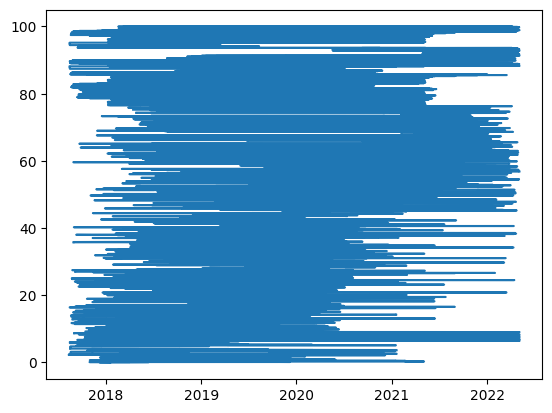

In [9]:
# In order to keep track of everyday balance, the transactions should be in sorted order 
# The line should be a continuous curve
plt.plot(df['date'].values, np.linspace(0, 100, len(df)))
plt.show()

In [10]:
# Sorted data frame by date
df.sort_values(by='date', ignore_index=True, inplace=True)

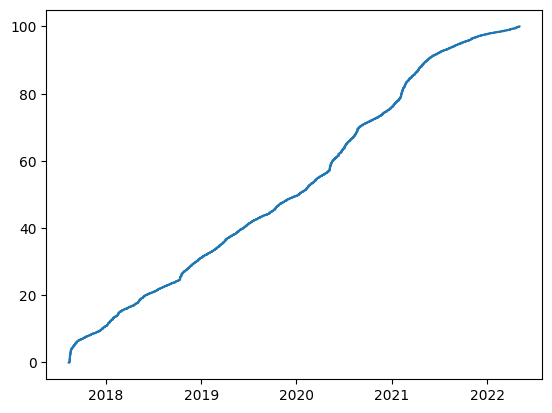

In [11]:
# Sorted w.r.t. date
plt.plot(df['date'].values, np.linspace(0, 100, len(df)))
plt.show()

In [12]:
# Calculates the net balance of each address on each date
def getNetBalance(df):
    df['from_balance'] = df['value']
    df['to_balance'] = df['value']

    # Create a new data frame with all the addresses on each date
    addresses = pd.concat([df['from_address'], df['to_address']]).unique()
    dates = df['date'].unique()
    df_final = pd.MultiIndex.from_product([dates, addresses], names=['date', 'address']).to_frame(index=False)
    
    # Merge the data w.r.t from_address and to_address
    df_final_from = df_final.merge(df[['date', 'from_address', 'from_balance']], how='left', left_on=['date', 'address'], right_on=['date', 'from_address'])
    df_final_from = df_final_from[['date', 'address', 'from_balance']]

    df_final_to = df_final.merge(df[['date', 'to_address', 'to_balance']], how='left', left_on=['date', 'address'], right_on=['date', 'to_address'])
    df_final_to = df_final_to[['date', 'address', 'to_balance']]

    # Add the from_balance and to_balance
    df_final_from = df_final_from.groupby(['date', 'address'])[['from_balance']].sum()
    df_final_to = df_final_to.groupby(['date', 'address'])[['to_balance']].sum()

    # Calculate the net balance
    df_final_net = pd.DataFrame(df_final_to['to_balance'] - df_final_from['from_balance'],columns=['net_balance'])
    df_final_net.reset_index(['date', 'address'], inplace=True)
    df_final_net['net_balance'] = df_final_net.groupby('address')['net_balance'].cumsum()
    return df_final_net

In [13]:
# Calculate gini coefficient
def gini(x):
    x = x.values
    x = x.flatten()
    if np.amin(x) < 0:
        x = x - np.amin(x)
    x = x + 10**-7
    x = np.sort(x)
    n = x.shape[0]
    index = np.arange(1, n+1)
    return ((np.sum((2 * index - n  - 1) * x)) / (n * np.sum(x)))

In [14]:
# Data frame with date, address, net balance
# Took 15min to run over 1/3rd of the data
temp = df.loc[:len(df)//3,:]
df_net = getNetBalance(temp)

In [25]:
df_net.sample(30, ignore_index=True)

,date,address,net_balance
0,2018-12-08,0x7023877fce6078214527d597a6296027d33d0b99,1.450432e+03
1,2018-10-25,0x2350c7f56c92b78b3591956b4ac3cd6890d878aa,1.583744e+03
2,2018-10-29,0x68bf72987deb0f86aede0ee8c012ac758bdf02f9,0.000000e+00
3,2019-01-02,0x4b9b02be0fc54e9bbad351858b27ab84f85865e4,0.000000e+00
4,2018-10-05,0xccfc6d875f7da17719a8a0ab7a36718a2e55dbec,0.000000e+00
5,2018-04-14,0x9e2d873a5deaf5e27cefe86a7a936b54416f08c2,6.869330e+02
6,2017-10-30,0xdb1bf0f2ae498cc2f3c81b1f1dee1599af59a8a1,0.000000e+00
7,2017-12-30,0x131415acc07e3410411b499f2de3c6d35eca3b63,0.000000e+00
8,2018-01-28,0xd76e368ab1cbebd67c251b716545d650f85cf507,0.000000e+00
9,2017-09-30,0xcf94be6a57ee5824c8f5ec30e94c40de266770c9,0.000000e+00


In [16]:
# Creating the final data frame with date and gini coefficient
df_final = pd.DataFrame(columns=['date', 'gini'])
df_final['date'] = df_net['date'].unique()

In [17]:
# Calculating the gini coefficient for each date
ginivals = df_net.groupby('date')['net_balance'].apply(gini).values
df_final['gini'] = ginivals

In [22]:
df_final.head(30)

,date,gini
0,2017-08-11,0.000008
1,2017-08-13,0.000008
2,2017-08-14,0.000008
3,2017-08-15,0.000008
4,2017-08-16,0.000008
5,2017-08-17,0.000008
6,2017-08-18,0.000008
7,2017-08-19,0.000008
8,2017-08-20,0.000008
9,2017-08-21,0.000008


In [20]:
ginivals

array([8.46997702e-06, 8.46997449e-06, 8.46997838e-06, 8.43875163e-06,
       8.41617874e-06, 8.42237898e-06, 8.42980447e-06, 8.43747219e-06,
       8.43810846e-06, 8.43913888e-06, 8.44044779e-06, 8.44061826e-06,
       8.44071228e-06, 8.44108984e-06, 8.44228856e-06, 8.44212049e-06,
       8.44201020e-06, 8.44204073e-06, 8.44287061e-06, 8.44268767e-06,
       8.44259991e-06, 8.44267885e-06, 8.44288768e-06, 8.44296384e-06,
       8.44273585e-06, 8.44248971e-06, 8.44265733e-06, 8.44208162e-06,
       8.44181698e-06, 8.44171368e-06, 8.44174797e-06, 8.44159685e-06,
       8.44158330e-06, 8.44166831e-06, 8.44188771e-06, 8.44169577e-06,
       8.44150232e-06, 8.44140408e-06, 8.44149459e-06, 8.44178278e-06,
       8.44177115e-06, 8.44176764e-06, 8.44172911e-06, 8.44179232e-06,
       8.44167546e-06, 8.44160861e-06, 8.44140614e-06, 8.44129362e-06,
       8.44124234e-06, 8.44127994e-06, 8.44131555e-06, 8.44121620e-06,
       8.44117908e-06, 8.44138567e-06, 8.44143333e-06, 8.44135089e-06,
      

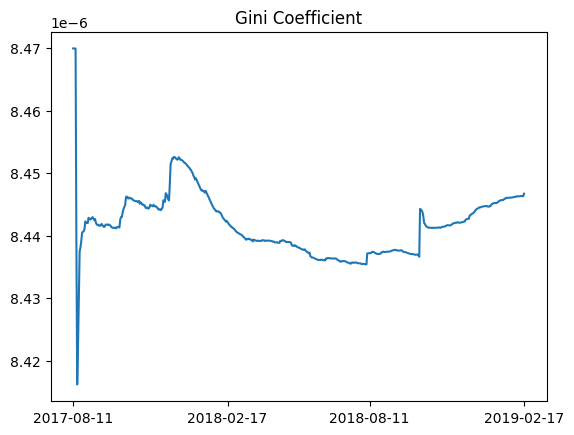

In [19]:
# Plotting the gini coefficient
plt.plot(df_final['date'], df_final['gini'])
plt.title('Gini Coefficient')
plt.xticks([datetime(2017,8,11),datetime(2018,2,17),datetime(2018,8,11), datetime(2019,2,17)])
plt.show()